In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [2]:
from multiprocessing import Pool
from tqdm import tqdm
def run_imap_multiprocessing(func, argument_list, num_processes):
    """
    Run a function in parallel using multiprocessing with a progress bar.

    Parameters:
    ----------
    func : function
        The function to be applied in parallel to each element of `argument_list`.
    
    argument_list : list
        List of arguments to be passed to `func`, each processed independently.
    
    num_processes : int
        Number of worker processes to spawn.

    Returns:
    -------
    list
        A list of results collected from applying `func` to each element in `argument_list`.

    Example:
    --------
    >>> def square(x):
    ...     return x ** 2
    >>> run_imap_multiprocessing(square, [1, 2, 3, 4], num_processes=2)
    [1, 4, 9, 16]

    Notes:
    ------
    - Uses `Pool.imap()` for memory efficiency (lazy evaluation).
    - Displays a progress bar via `tqdm` for tracking completion.
    - Ensure `if __name__ == "__main__":` when calling this in a script to prevent issues on Windows.
    """
    with Pool(processes=num_processes) as pool:
        result_list_tqdm = []
        for result in tqdm(pool.imap(func=func, iterable=argument_list), total=len(argument_list)):
            result_list_tqdm.append(result)

    return result_list_tqdm

In [3]:
from subprocess import run, PIPE, Popen
def get_align_perc_old(species):
    coverage = Popen(["bedtools", "coverage",
                      "-a", "/home/moorej3/Lab/ENCODE/Encyclopedia/V7/Registry/V7-hg38/hg38-TF/test-filtering.txt",
                      "-b", "/zata/zippy/andrewsg/data/zoonomia/BED/" + species + ".bg"], stdout=PIPE)

    p = []
    for line in coverage.stdout:
        split = str(line, encoding="utf-8").strip().split("\t")
        p.append(float(split[-1]))
    return(np.array(p))

In [4]:
species_list = sorted([x.split('.')[0] for x in os.listdir('/zata/zippy/andrewsg/data/zoonomia/BED')])

In [5]:
X = run_imap_multiprocessing(get_align_perc_old, species_list, 64)

100%|████████████████████████████████████████████████████████████| 240/240 [02:03<00:00,  1.94it/s]


In [6]:
X = np.stack(X).T

In [7]:
X.shape

(2030597, 240)

In [8]:
X = pd.DataFrame(X, columns=species_list)
N1 = np.sum(1 * X.ge(.9).values, axis=1)
N2 = np.sum(1 * X.le(.1).values, axis=1)

In [9]:
out=open("/home/moorej3/Lab/ENCODE/Encyclopedia/V7/Registry/V7-hg38/hg38-TF/TF-N1-N2.txt", "w+")
i=0
for entry in N1:
    print(str(entry)+"\t"+str(N2[i]), file=out)
    i +=1
out.close()

In [20]:
N2[0:10]

array([157,  58,  42,  38,  32,  56, 110,  62,  14,  62])

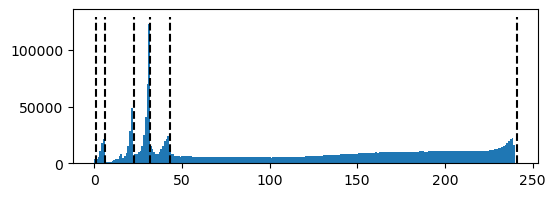

In [13]:
fig, ax = plt.subplots(figsize=(6,2))
_ = ax.hist(N1, 241)
ymin, ymax = ax.get_ylim()
ax.vlines(x = [1,6,23,32,43,241], 
          ymin=ymin,
          ymax=ymax,
          color='k', linestyles='--')